# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
#--------------------------------------------------------------------#
#---------------------------basic imports----------------------------#
#--------------------------------------------------------------------#
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
#====================================================================#
 
    
#---------------------------------------------------------------------#
#--------------------setting directories------------------------------#
#---------------------------------------------------------------------#
ROOT_DIR = os.getcwd()
print(ROOT_DIR)
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
mrcnn_path=os.path.join(ROOT_DIR, 'Mask_RCNN')
print(mrcnn_path)

# Import Mask RCNN
#sys.path.append(ROOT_DIR)  # To find local version of the library
sys.path.append(mrcnn_path) #making sure it looks for mrcnn 
#=====================================================================#


#-------------------------------------------------------------------#
#--------------------import everthing RCNN--------------------------#
#-------------------------------------------------------------------#
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
#====================================================================#

print("done importing everything")

#--------------------------------------------------------------------#
#-------------Download default network weights trained on coc--------#
#--------------------------------------------------------------------#

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print('not')
    utils.download_trained_weights(COCO_MODEL_PATH)
#=====================================================================#

/home/rajat/Documents/MS/Fall 2018/CSE599/project
/home/rajat/Documents/MS/Fall 2018/CSE599/project/Mask_RCNN


Using TensorFlow backend.


AssertionError: 

In [ ]:
# import pickle
# import os
# path="/home/ubuntu/Dropbox/Mask_RCNN-master/data/train/"
# indpath=path+"train_index.pkl"
# fr=open(indpath,'rb')
# inds=pickle.load(fr)

#for i, ind in enumerate(inds):
#    if i!=1027:
#       if i>1027:
#            i=i-1    
#        imgpath=path+"full0/"+str(ind)+".png"
#        img=cv2.imread(imgpath)
#
#        imgpath_new=path+"full/"+str(i)+".png"
    #     print(imgpath_new)
#        cv2.imwrite(imgpath_new,img)
    
# for i, ind in enumerate(inds):
#      if i!=1027:
#         if i>1027:
#              i=i-1
#         maskpath=path+"mask0/"+str(ind)+".npz"
#         savepath=path+"mask/"+str(i)+".npz"
#         os.rename(maskpath,  savepath)
        
#         data=np.load(maskpath)
#         c_id=data['class_id']
#         mask=data['mask']

#         obj={}
#         if not isinstance(c_id,list):
#             c_id=[c_id]
#         obj['class_id']=c_id
#         obj['mask']=mask
#         
#         np.save(savepath, obj)

## Configurations

In [21]:
class networkConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # just 1 cancer type
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 2048
    IMAGE_MAX_DIM = 2048

    # Use smaller anchors because our image and objects are small
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 12
    
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50
    
#     BACKBONE="resnet101"
    
    RPN_ANCHOR_SCALES=(16, 32, 64, 128, 256)
    
    IMAGE_CHANNEL_COUNT = 3 #grayscale
    
    MAX_GT_INSTANCES=6
    
#     MEAN_PIXEL = [123.7 116.8 103.9] #rgb img
    MEAN_PIXEL = (67.6,65.8,0.2) #gray img
    
    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.5,
        "mrcnn_mask_loss": 0.5
    }
    
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM=0.9
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  2048
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  2048
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [2048 2048    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.5, 'mrcnn_mask_loss': 0.5}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Notebook Preferences

In [22]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [79]:
class DDSMDataset(utils.Dataset):
    """ GC: The DDSM data"""
    def get_obj_number(self, mask):
        n = np.max(mask)
        print('obj_num',n)
        return n
    def load_shapes(self, count, height, width, img_folder, mask_folder):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("mass", 1, "mass")

        # Add images
        for i in range(count):
            img_path = img_folder + "/" + str(i) + ".npz"
            mask_path = mask_folder + "/" + str(i) + ".npz"
            self.add_image("mass", image_id=i, path=img_path, width=width, height=height, 
                           mask_path=mask_path,scale=None, padding=None, crop=None)
    def load_image(self, image_id):
        info = self.image_info[image_id]
#         image = cv2.imread(info['path'])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img = np.load(info['path'])
        image = img['img']
        image, window, scale, padding, crop=utils.resize_image(image, min_dim=config.IMAGE_MIN_DIM, 
                                                         max_dim=config.IMAGE_MAX_DIM, min_scale=None, mode="square")
        info['scale']=scale
        info['padding']=padding
        info['crop']=crop
        self.image_info[image_id]=info
        
        return image
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "mass":
            return info["mass"]
        else:
            super(self.__class__).image_reference(self, image_id)
            
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        info = self.image_info[image_id]  
        mask_obj = np.load(info['mask_path'])
        mask=mask_obj['mask']
        shapes=mask_obj['class_id']
        shapes=shapes[0]
#         print(shapes)
        #print("############shapes",shapes)
        count = len(shapes)
#         num_obj = self.get_obj_number(mask)
#         mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        #mask = np.array(mask)   
        #resize mask
        
        if count == 1:
            mask = mask.transpose(1, 2, 0)
        #print(mask.shape)
        scale=info['scale']
        padding=info['padding']
        crop=info['crop']
        mask=utils.resize_mask(mask, scale, padding, crop)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
#         if count == 1:
#             class_ids = np.array([1])
#         else:
#             class_ids = np.array(shapes)
        class_ids = np.array(shapes)
        #print(mask.shape)
        return mask.astype(np.bool), class_ids.astype(np.int32)


In [80]:
## Path set
traindata_root_path=""
valdata_root_path=""

img_folder_train = traindata_root_path+"full"
mask_folder_train = traindata_root_path+"mask"

img_folder_val = testdata_root_path+"full"
mask_folder_val = testdata_root_path+"mask"

count_train=1164
count_val=1164
config.IMAGE_SHAPE[0]

2048

In [81]:
# Training dataset

dataset_train = DDSMDataset()
dataset_train.load_shapes(count_train, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], img_folder_train, mask_folder_train)
dataset_train.prepare()

# Validation dataset
dataset_val = DDSMDataset()
dataset_val.load_shapes(count_val, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], img_folder_val, mask_folder_val)
dataset_val.prepare()

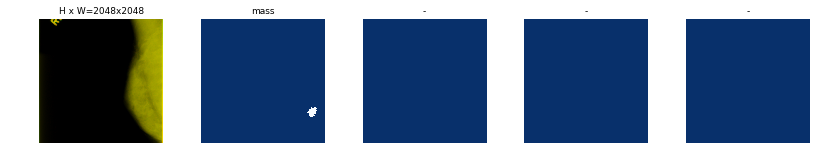

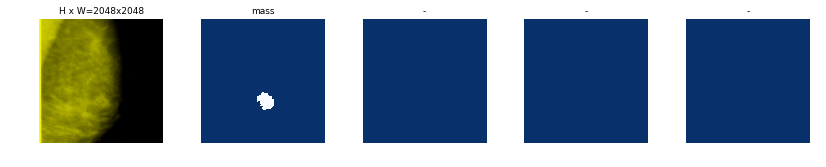

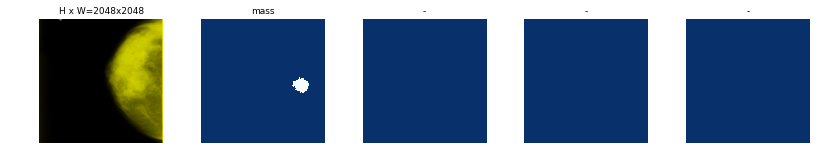

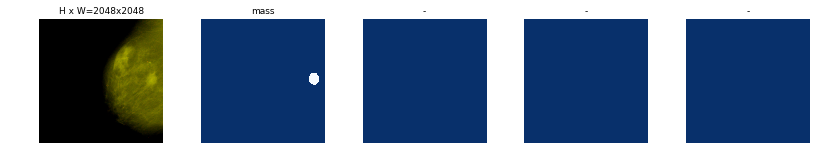

In [82]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
# print(image_ids)
for image_id in image_ids:
#     image_id=26
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [83]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [84]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='heads')                                # rgb img
#             layers=r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)|conv1" ) #grayscale img


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/Dropbox/Mask_RCNN-master/logs/shapes20181208T1547/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistrib

/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
100/100 [==============================] - 134s 1s/step - loss: 1.6809 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3466 - mrcnn_class_loss: 0.2818 - mrcnn_bbox_loss: 0.7945 - mrcnn_mask_loss: 0.2475 - val_loss: 3.0317 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 1.0589 - val_mrcnn_class_loss: 0.4432 - val_mrcnn_bbox_loss: 1.2198 - val_mrcnn_mask_loss: 0.3071


In [14]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100, 
            layers="all")


Starting at epoch 50. LR=0.0001

Checkpoint Path: /home/ubuntu/Dropbox/Mask_RCNN-master/logs/shapes20181206T1048/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (

/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 51/100


ResourceExhaustedError: OOM when allocating tensor with shape[1,1024,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node res4s_branch2c/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_53/Relu, res4s_branch2c/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node proposal_targets/strided_slice_16/_9365}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_8094_proposal_targets/strided_slice_16", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [44]:
class InferenceConfig(networkConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/Dropbox/Mask_RCNN-master/logs/shapes20181208T1400/mask_rcnn_shapes_0044.h5
Re-starting from epoch 44


original_image           shape: (2048, 2048, 3)       min:    0.00000  max:  220.31262  float64
image_meta               shape: (14,)                 min:    0.00000  max: 2048.00000  int64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  754.00000  max: 1767.00000  int32
gt_mask                  shape: (2048, 2048, 1)       min:    0.00000  max:    1.00000  bool


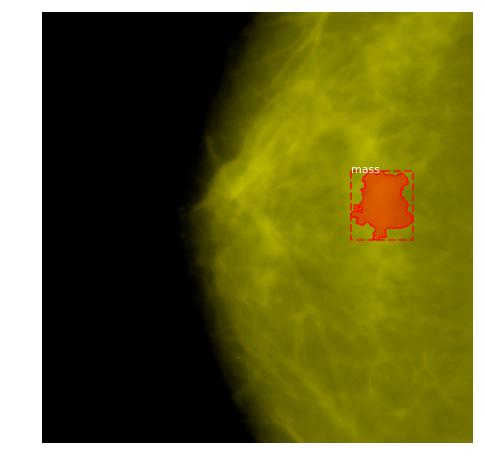

In [56]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
image_id=199
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (2048, 2048, 3)       min:    0.00000  max:  220.31262  float64
molded_images            shape: (1, 2048, 2048, 3)    min:  -67.60000  max:  152.71262  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  int64
anchors                  shape: (1, 1047552, 4)       min:   -0.08843  max:    1.05717  float32


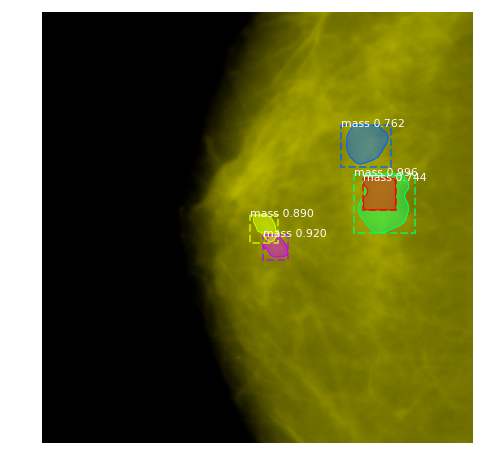

In [57]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [75]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 2)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image_id=1026
    print("current id",image_id)
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

current id 1026
[1 1]
current id 1026
[1 1]
mAP:  0.0
